Представимо початкові дані графiчно, розіб'ємо їх на навчальний та валiдацiйний набори:

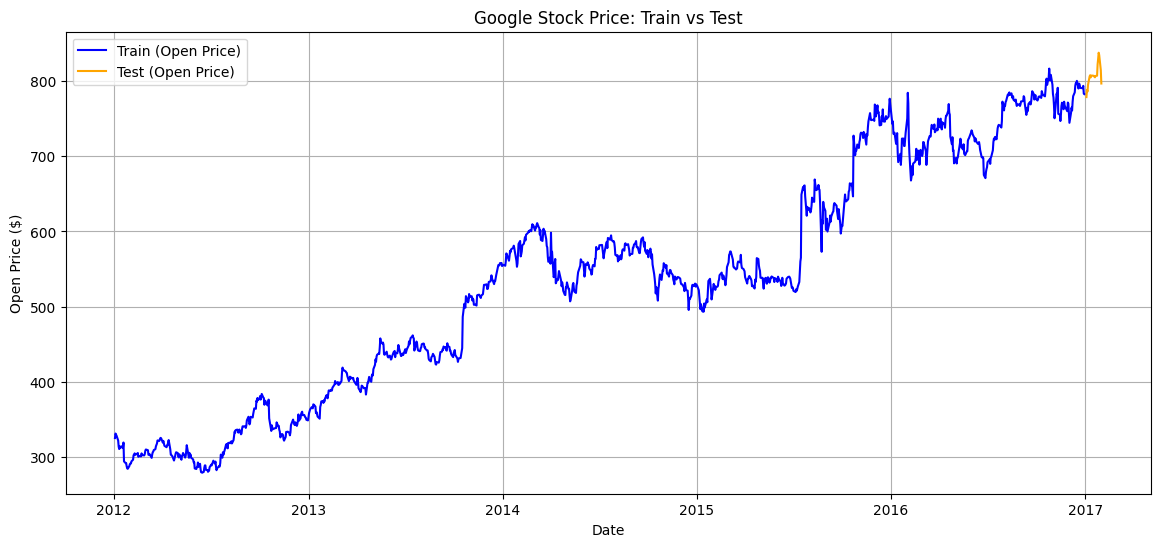

Розмір навчального набору: 1006
Розмір валідаційного набору: 252


C:\Users\User\AppData\Local\Temp\ipykernel_18020\883025958.py:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = train_df['Open'].shift(-1).fillna(method='ffill').values


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

train_df = pd.read_csv("Google_Stock_Price_Train.csv")
test_df = pd.read_csv("Google_Stock_Price_Test.csv")

train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])
train_df['Open'] = pd.to_numeric(train_df['Open'], errors='coerce')
test_df['Open'] = pd.to_numeric(test_df['Open'], errors='coerce')

plt.figure(figsize=(14, 6))
plt.plot(train_df['Date'], train_df['Open'], label='Train (Open Price)', color='blue')
plt.plot(test_df['Date'], test_df['Open'], label='Test (Open Price)', color='orange')
plt.title("Google Stock Price: Train vs Test")
plt.xlabel("Date")
plt.ylabel("Open Price ($)")
plt.legend()
plt.grid(True)
plt.show()

X = train_df[['Open']].values
y = train_df['Open'].shift(-1).fillna(method='ffill').values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print(f"Розмір навчального набору: {len(X_train)}")
print(f"Розмір валідаційного набору: {len(X_val)}")

Побудуємо на навчальному наборi даних моделi регресiї та представимо їх графічно:

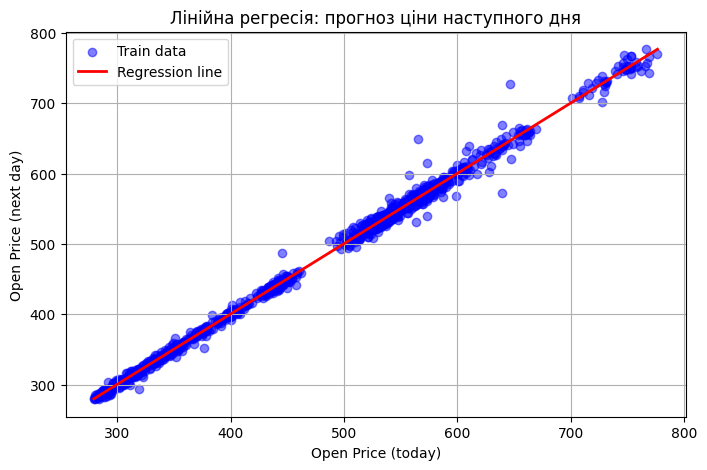

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

model = LinearRegression(fit_intercept=True)
model.fit(X_train, y_train)

plt.figure(figsize=(8, 5))
plt.scatter(X_train, y_train, color="blue", alpha=0.5, label="Train data")

x_line = np.linspace(X_train.min(), X_train.max(), 100).reshape(-1, 1)
y_line = model.predict(x_line)
plt.plot(x_line, y_line, color="red", linewidth=2, label="Regression line")

plt.xlabel("Open Price (today)")
plt.ylabel("Open Price (next day)")
plt.title("Лінійна регресія: прогноз ціни наступного дня")
plt.legend()
plt.grid(True)
plt.show()

Виконаємо прогнози на основi побудованих моделей та оцінимо чи має місце перенавчання:

In [3]:
y_train_pred = model.predict(X_train)
y_val_pred   = model.predict(X_val)

def regression_metrics(y_true, y_pred, name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{name} → RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    return rmse, mae, r2

print("\n Оцінка моделі ")
rmse_train, mae_train, r2_train = regression_metrics(y_train, y_train_pred, "Train")
rmse_val,   mae_val,   r2_val   = regression_metrics(y_val,   y_val_pred,   "Validation")

print("\nПеревірка перенавчання:")
if abs(r2_train - r2_val) > 0.1:
    print("Є ризик перенавчання")
else:
    print(" Перенавчання не виявлено")


 Оцінка моделі 
Train → RMSE: 8.0416, MAE: 5.0092, R²: 0.9956
Validation → RMSE: 9.7055, MAE: 7.0434, R²: 0.9224

Перевірка перенавчання:
 Перенавчання не виявлено


Розрахуємо для кожної моделi коефiцiєнт детермiнацiї R2, помилки RMSE, MAE окремо на навчальнiй та валiдацiйнiй множинах:

In [5]:
print("\n Підсумкові метрики ")
print(f"Train: RMSE={rmse_train:.4f}, MAE={mae_train:.4f}, R²={r2_train:.4f}")
print(f"Val:   RMSE={rmse_val:.4f}, MAE={mae_val:.4f}, R²={r2_val:.4f}")


 Підсумкові метрики 
Train: RMSE=8.0416, MAE=5.0092, R²=0.9956
Val:   RMSE=9.7055, MAE=7.0434, R²=0.9224


Тепер виконаємо решiтчастий пошук (grid search) для пiдбору гiперпараметрiв моделей:

In [6]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "fit_intercept": [True, False],
    "positive": [False, True]
}

gs = GridSearchCV(
    estimator=LinearRegression(),
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1
)

gs.fit(X_train, y_train)
best_lr = gs.best_estimator_

print("\n Grid Search ")
print("Найкращі параметри:", gs.best_params_)
print("Найкращий CV-RMSE:", np.sqrt(-gs.best_score_))

y_val_pred_gs = best_lr.predict(X_val)
print("Validation RMSE (best):", np.sqrt(mean_squared_error(y_val, y_val_pred_gs)))



 Grid Search 
Найкращі параметри: {'fit_intercept': False, 'positive': False}
Найкращий CV-RMSE: 8.05086911746282
Validation RMSE (best): 9.720754351117089


Проведемо порівняння базової та налаштованої за GridSearch моделей лінійної регресії за метриками RMSE, MAE та R², що дозволить визначити кращу за точністю модель. Дослідимо залежність якості прогнозу від обсягу навчальних даних за допомогою кривої навчання, результати подамо графічно та у вигляді таблиці:


 Порівняння моделей (Validation) 
Baseline LR: {'RMSE': np.float64(9.70546699310102), 'MAE': 7.043400991200616, 'R2': 0.9224391835103383}
GridSearch LR: {'RMSE': np.float64(9.720754351117089), 'MAE': 7.052326050530387, 'R2': 0.9221946545689761}
Висновок: краща за RMSE модель — Baseline


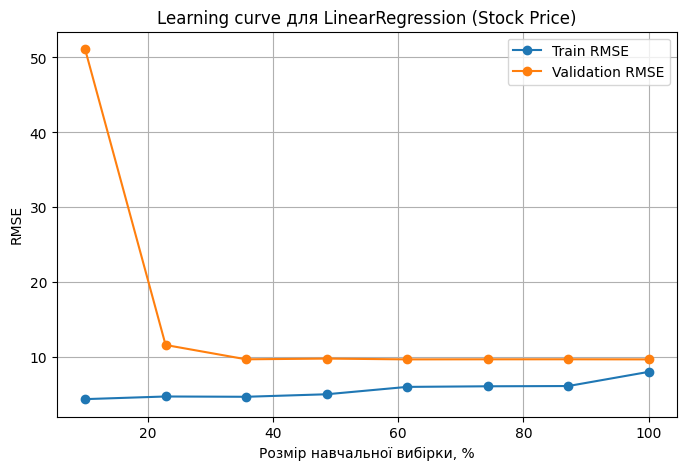


 Learning curve (таблиця) 
 train_percent  RMSE_train  RMSE_val
            10       4.403    51.095
            23       4.755    11.625
            36       4.716     9.715
            49       5.051     9.812
            61       6.035     9.705
            74       6.116     9.715
            87       6.149     9.718
           100       8.042     9.705


In [7]:
def metrics_dict(y_true, y_pred):
    return {
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2":  r2_score(y_true, y_pred)
    }

baseline_metrics = metrics_dict(y_val, y_val_pred)
gs_metrics       = metrics_dict(y_val, y_val_pred_gs)

print("\n Порівняння моделей (Validation) ")
print("Baseline LR:", baseline_metrics)
print("GridSearch LR:", gs_metrics)

chosen = "Baseline" if baseline_metrics["RMSE"] <= gs_metrics["RMSE"] else "GridSearch"
print(f"Висновок: краща за RMSE модель — {chosen}")

train_fracs = np.linspace(0.1, 1.0, 8)
rmse_train_curve, rmse_val_curve = [], []

for frac in train_fracs:
    n_sub = max(5, int(len(X_train) * frac))
    X_sub, y_sub = X_train[:n_sub], y_train[:n_sub]

    m = LinearRegression(fit_intercept=True)
    m.fit(X_sub, y_sub)

    rmse_train_curve.append(np.sqrt(mean_squared_error(y_sub, m.predict(X_sub))))
    rmse_val_curve.append(np.sqrt(mean_squared_error(y_val, m.predict(X_val))))

plt.figure(figsize=(8, 5))
plt.plot(train_fracs * 100, rmse_train_curve, marker="o", label="Train RMSE")
plt.plot(train_fracs * 100, rmse_val_curve, marker="o", label="Validation RMSE")
plt.xlabel("Розмір навчальної вибірки, %")
plt.ylabel("RMSE")
plt.title("Learning curve для LinearRegression (Stock Price)")
plt.legend()
plt.grid(True)
plt.show()

lc_df = pd.DataFrame({
    "train_percent": (train_fracs * 100).round(0).astype(int),
    "RMSE_train": np.round(rmse_train_curve, 3),
    "RMSE_val":   np.round(rmse_val_curve, 3)
})
print("\n Learning curve (таблиця) ")
print(lc_df.to_string(index=False))



Висновок: більший обсяг навчальної вибірки значно покращує якість моделі на початкових етапах, а після певного порогу ефект від додавання даних зменшується, і модель досягає стабільного рівня точності.